## What is a classification problem?
A classification problem involves predicting whether something is one thing or another.

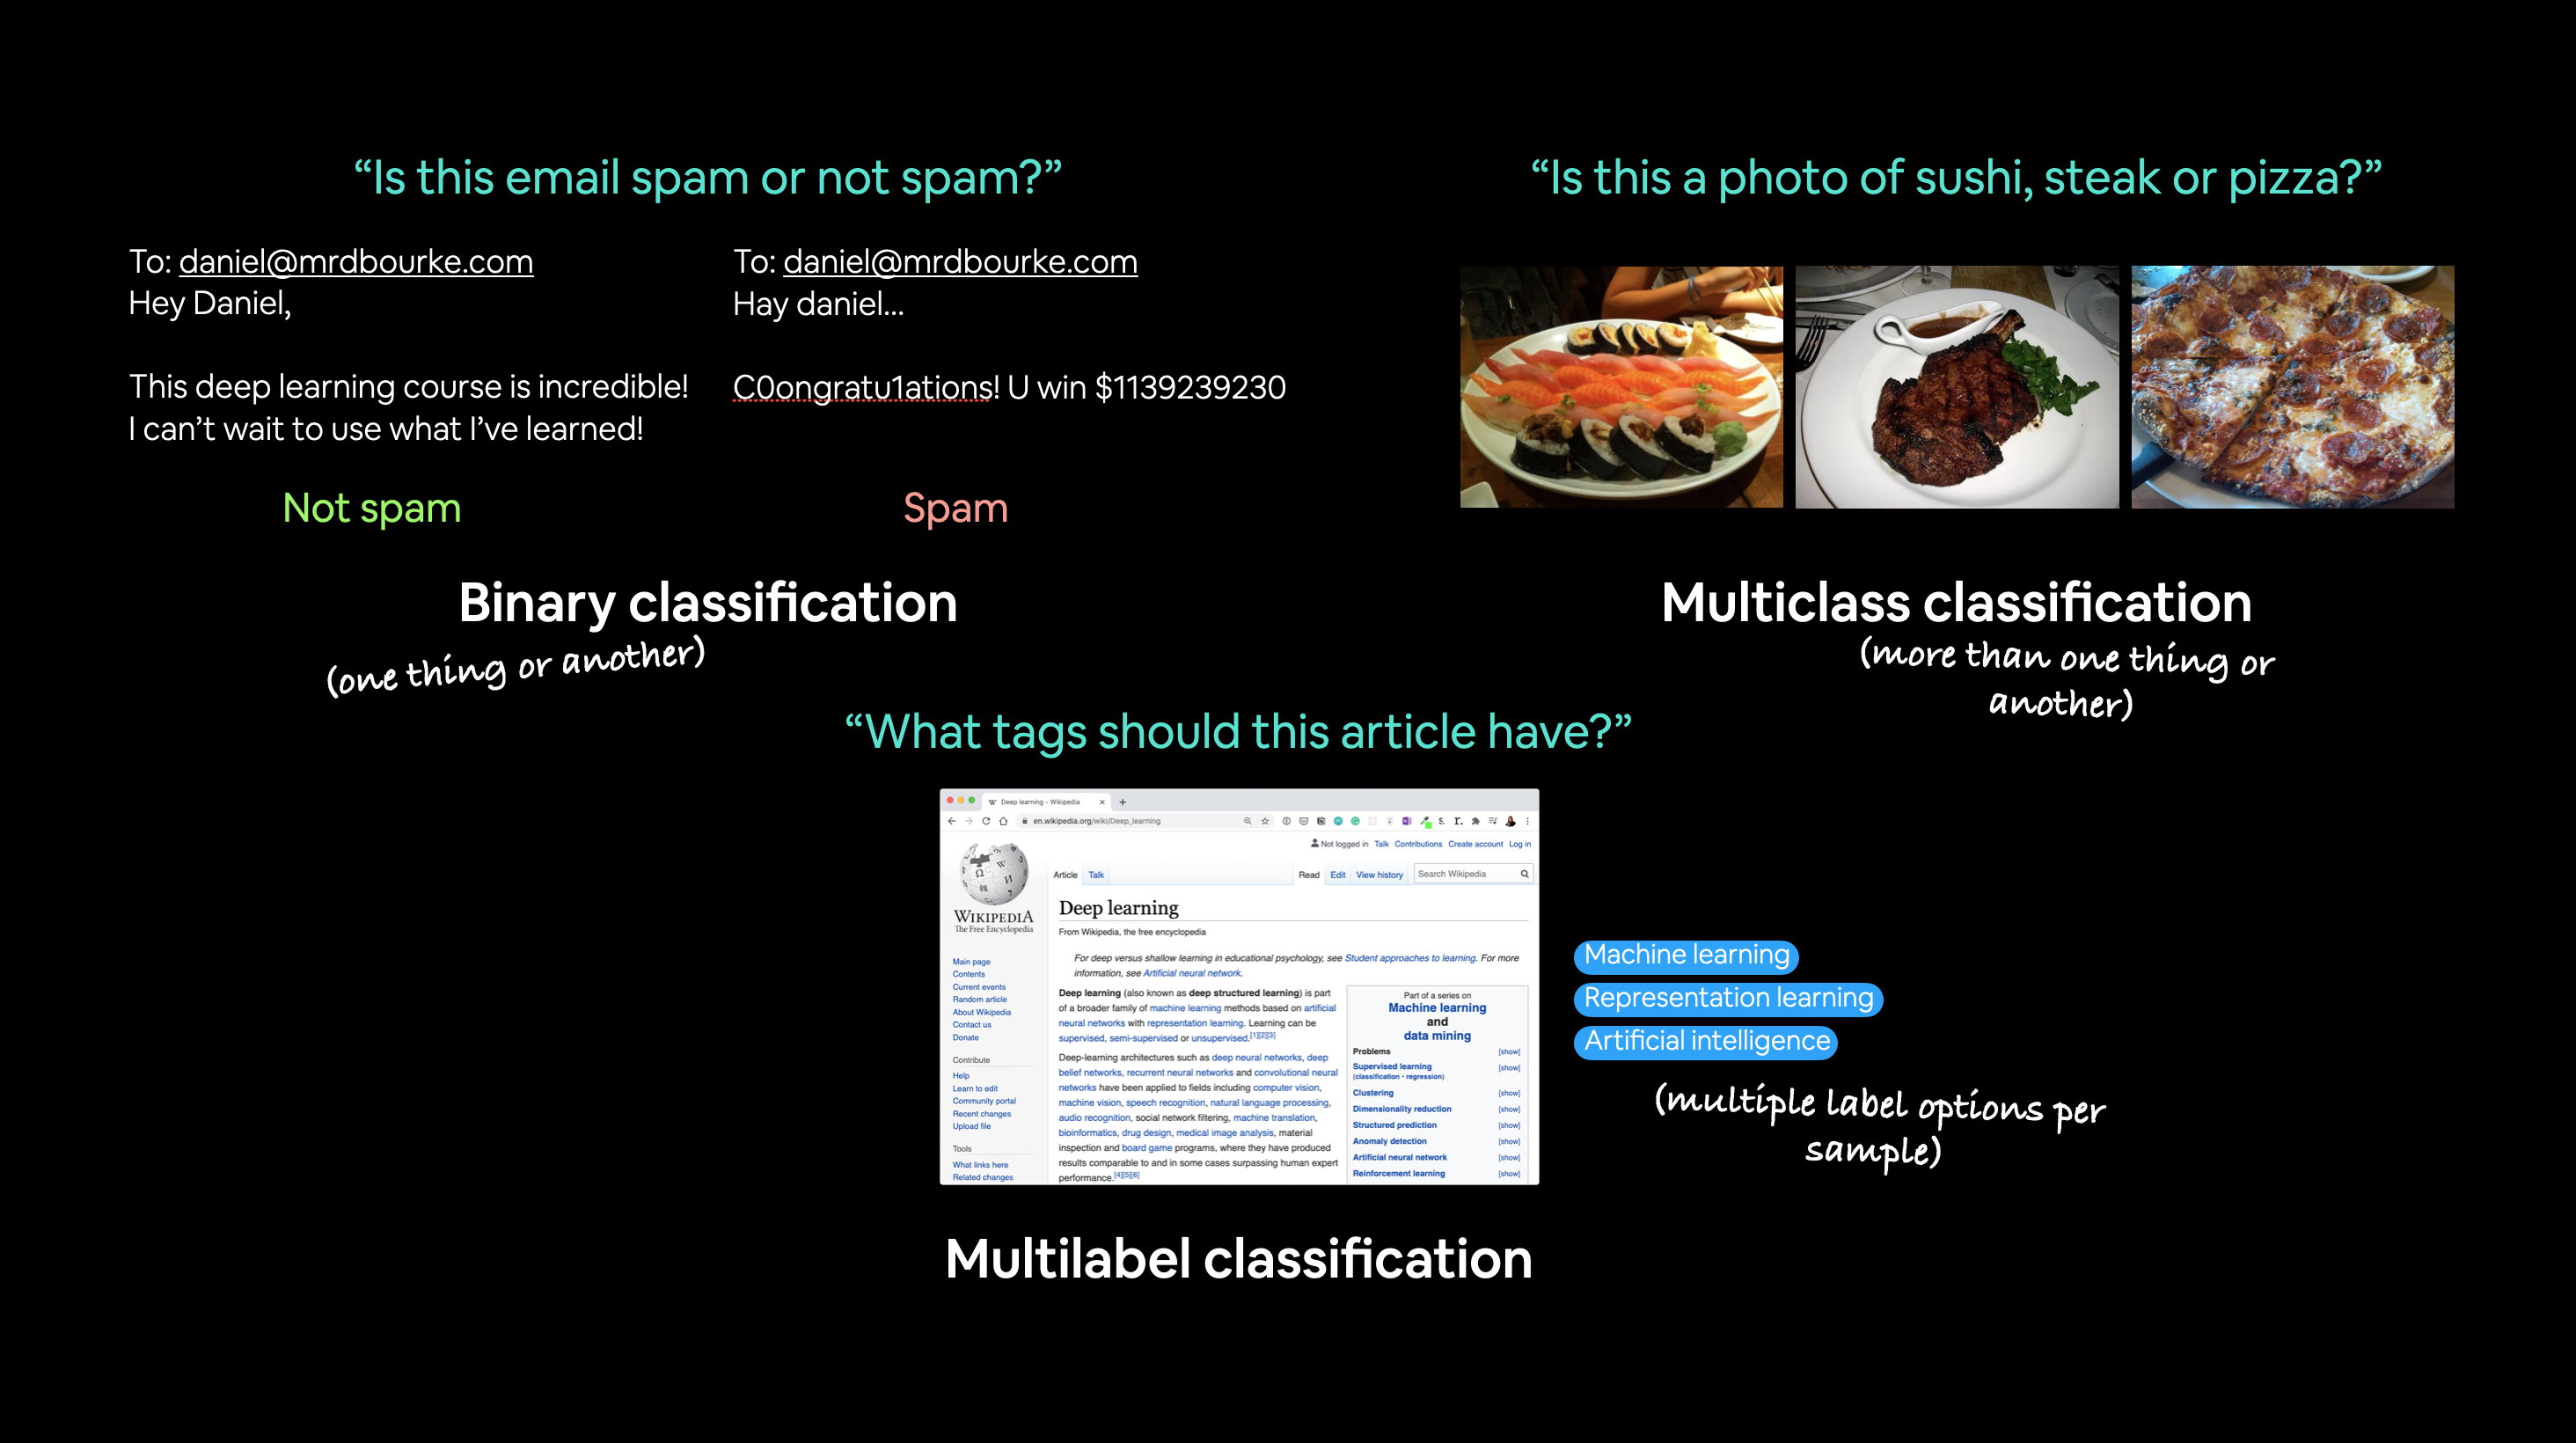

In [2]:
# import the necessary libraries/modules
import torch
import torch.nn as nn

In [3]:
# create a function to print model parameters
def get_model_parameters(model) -> None:
    """
    Prints the parameters of the provided model.

    Args:
      model: The PyTorch model whose parameters need to be printed.

    Returns:
      None
    """

    for parameter, value in model.state_dict().items():
        print(f'{parameter}: {value}')

## 1. Make classification data and get it ready

let's create a toy dataset using `sklearn.datasets`

In [4]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circle
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

len(X), len(y)

(1000, 1000)

In [5]:
# make dataframe of the data
import pandas as pd

data = pd.DataFrame({'X1': X[:, 0],
                     'X2': X[:, 1],
                    'label': y})

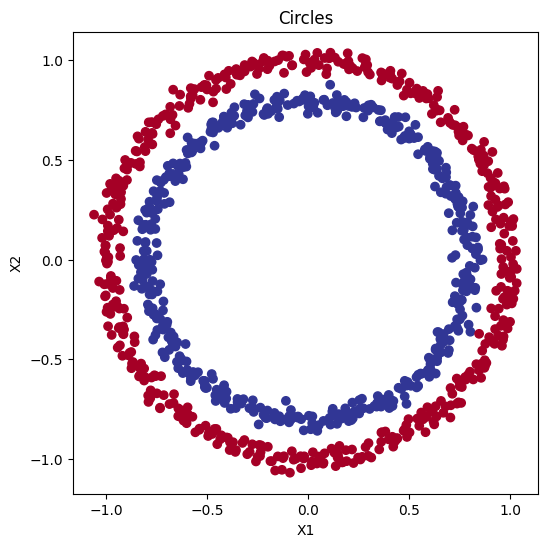

In [6]:
# visualize the data
import matplotlib.pyplot as plt

# plot a scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x=data['X1'],
            y=data['X2'],
            c=data['label'],
            cmap=plt.cm.RdYlBu)

# define the labels
plt.xlabel('X1')
plt.ylabel('X2')

# define title
plt.title('Circles')


plt.show()

In [7]:
# get dataset shape
print(f'X: {X.shape}, y: {y.shape}')

# get individual shapes
print(f'X[0]: {X[0].shape}, y[0]: {y[0].shape}')

X: (1000, 2), y: (1000,)
X[0]: (2,), y[0]: ()


## 2. Turn the data into Tensors and create a train and test split

In [8]:
# turn the data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# check the data type
X.dtype, y.dtype

(torch.float32, torch.float32)

In [9]:
# split the data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Let's build a model to classify our data using PyTorch...

To do:
1. Setup device agnostic code for `cuda`
2. Construct a model
3. Define loss function and optimizer
4. Build a training loop and test loop

### 3.1 Setup device agnostic code

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
!nvidia-smi

Thu Oct  3 17:11:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 3.2 Construct a model

In [12]:
# setup random seed
torch.manual_seed(42)

# setup model class, subclassing nn.Module
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()

        # create 2 nn.linear layers for our data shape
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=5) # takes in our 2 labels and upscales them to 5
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=1) # takes in 5 processed features from layer_1 and gives the final output

    # define the forward propogation method
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output


# instantiate a model instance class
model_0 = CircleModel().to(device)

In [13]:
# let's see model parameters
get_model_parameters(model_0)

layer_1.weight: tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], device='cuda:0')
layer_1.bias: tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')
layer_2.weight: tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')
layer_2.bias: tensor([-0.2060], device='cuda:0')


### 3.3 Make untrained predictions

In [14]:
# making model prediction using inference_mode()
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

untrained_preds[:10]

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0')

### 3.4 Setup up loss funtion, optimizer and evaluation metric

In [15]:
# setup loss function
loss_fn = nn.BCEWithLogitsLoss() # has built in signmoid function

# setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [16]:
# create an accuracy function
def accuracy_fn(y_true, y_pred):
    """
    Calculates the accuracy of the model.

    Args:
      y_true: The true labels of the data.
      y_pred: The predicted labels of the data.

    Returns:
      The accuracy of the model.
    """

    # get the number of correct predictions
    correct = torch.eq(y_true, y_pred).sum().item()

    # setup accuracy formula
    acc = (correct / len(y_pred)) * 100

    # return accuracy
    return acc

### 3.5 **Raw Logits -> Prediction Probability -> Prediction Label**
**Logits:** Raw model outputs *(without activation function)*

**Prediction Probability:** Processed Outputs *(With activation function)*

**Prediction Label:** Output label

In [17]:
# get model logits
model_0.eval()

with torch.inference_mode():
    logits = model_0(X_test.to(device))[:5]

logits[:5]

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

In [18]:
# apply sigmoid activation to the logits manually to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(logits)

# check the prediction probabilities
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

In [19]:
# perform range-style rounding on the prediction probabilities
y_preds = torch.round(y_pred_probs).squeeze()

# check the prediction labels
y_preds

tensor([0., 0., 0., 0., 0.], device='cuda:0')

### 3.6 Train and Test model

1. Forward pass
2. Calculate the loss
3. Optimizer Zero grad
4. Loss Backwards (Backpropogation)
5. Optimizer Step (Gradient Descent)


In [20]:
# setup random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epoch count
epochs = 100

# put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# setup training and evaluation loop
for epoch in range(epochs):
    model_0.train()

    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss and accuracy
    train_loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backwards (backpropogation)
    train_loss.backward()

    # optimizer step
    optimizer.step()


    # test the model
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # print what is happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {acc:.2f}%')
        print(f'Epoch: {epoch} | Test Loss: {test_loss:.5f} | Test Accuracy: {acc:.2f}% \n')

Epoch: 0 | Train Loss: 0.69569 | Train Accuracy: 50.00%
Epoch: 0 | Test Loss: 0.69721 | Test Accuracy: 50.00% 

Epoch: 10 | Train Loss: 0.69403 | Train Accuracy: 50.00%
Epoch: 10 | Test Loss: 0.69615 | Test Accuracy: 50.00% 

Epoch: 20 | Train Loss: 0.69343 | Train Accuracy: 46.00%
Epoch: 20 | Test Loss: 0.69585 | Test Accuracy: 46.00% 

Epoch: 30 | Train Loss: 0.69321 | Train Accuracy: 49.00%
Epoch: 30 | Test Loss: 0.69577 | Test Accuracy: 49.00% 

Epoch: 40 | Train Loss: 0.69312 | Train Accuracy: 49.50%
Epoch: 40 | Test Loss: 0.69573 | Test Accuracy: 49.50% 

Epoch: 50 | Train Loss: 0.69308 | Train Accuracy: 50.38%
Epoch: 50 | Test Loss: 0.69569 | Test Accuracy: 50.38% 

Epoch: 60 | Train Loss: 0.69306 | Train Accuracy: 50.50%
Epoch: 60 | Test Loss: 0.69564 | Test Accuracy: 50.50% 

Epoch: 70 | Train Loss: 0.69305 | Train Accuracy: 50.50%
Epoch: 70 | Test Loss: 0.69559 | Test Accuracy: 50.50% 

Epoch: 80 | Train Loss: 0.69304 | Train Accuracy: 50.75%
Epoch: 80 | Test Loss: 0.69553 | 

### 3.7 Vizualize model using helper function

In [23]:
# import matplotlib for vizualization
import matplotlib.pyplot as plt

# import helper function
from helper_functions import plot_decision_boundary

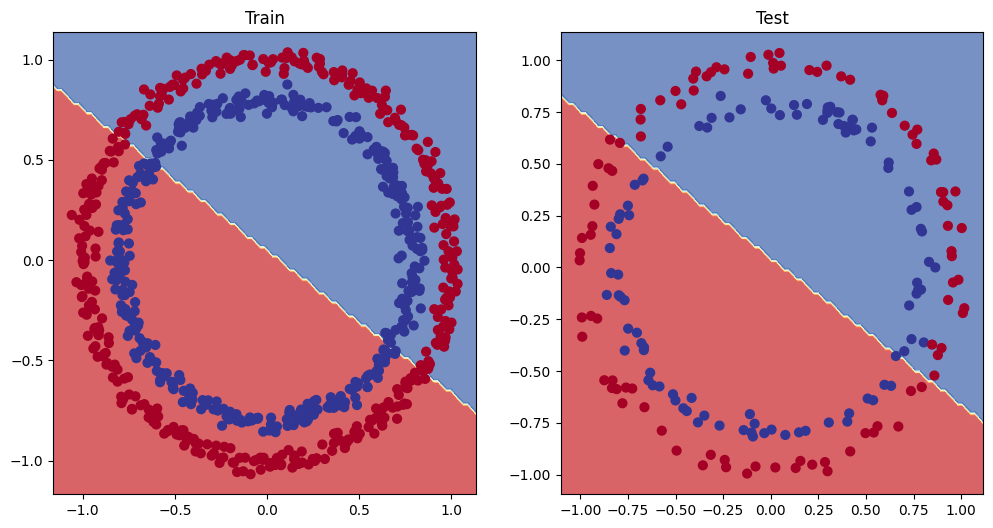

In [24]:
# define figure size
plt.figure(figsize=(12, 6))

# define subplot for training data
plt.subplot(1, 2, 1)
plt.title('Train')

# plot training data decision boundary
plot_decision_boundary(model_0, X_train, y_train)


# define subplot for test data
plt.subplot(1, 2, 2)
plt.title('Test')

# plot test data decision boundary
plot_decision_boundary(model_0, X_test, y_test)

As you can see, we are not able to separate two circles using only linear layers in our model... Let's improve it!!!

# 4. Improve Model (from a model perspective)

* **Add more layers:** Gives chance to learn more patterns
* **Add more hidden units** (neurons)
* **Fit for longer (more epochs)**
* **Change activation functions**
* **Change learning rate**
* **Change loss function**

In [25]:
# create a better model with more layers and hidden units (neurons)

class BetterCircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        # define model layers
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    # define forward propogation
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

# instanciate the model
model_1 = BetterCircleModelV1().to(device)

# view model
model_1

BetterCircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
# setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [27]:
# setup random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epoch count
epochs = 100

# put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# setup training and evaluation loop
for epoch in range(epochs):
    model_1.train()

    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss and accuracy
    train_loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backwards (backpropogation)
    train_loss.backward()

    # optimizer step
    optimizer.step()


    # test the model
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # print what is happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {acc:.2f}%')
        print(f'Epoch: {epoch} | Test Loss: {test_loss:.5f} | Test Accuracy: {acc:.2f}% \n')

Epoch: 0 | Train Loss: 0.69396 | Train Accuracy: 50.88%
Epoch: 0 | Test Loss: 0.69261 | Test Accuracy: 50.88% 

Epoch: 10 | Train Loss: 0.69369 | Train Accuracy: 50.25%
Epoch: 10 | Test Loss: 0.69270 | Test Accuracy: 50.25% 

Epoch: 20 | Train Loss: 0.69351 | Train Accuracy: 50.12%
Epoch: 20 | Test Loss: 0.69283 | Test Accuracy: 50.12% 

Epoch: 30 | Train Loss: 0.69339 | Train Accuracy: 50.50%
Epoch: 30 | Test Loss: 0.69297 | Test Accuracy: 50.50% 

Epoch: 40 | Train Loss: 0.69329 | Train Accuracy: 50.38%
Epoch: 40 | Test Loss: 0.69310 | Test Accuracy: 50.38% 

Epoch: 50 | Train Loss: 0.69322 | Train Accuracy: 49.88%
Epoch: 50 | Test Loss: 0.69324 | Test Accuracy: 49.88% 

Epoch: 60 | Train Loss: 0.69317 | Train Accuracy: 49.38%
Epoch: 60 | Test Loss: 0.69336 | Test Accuracy: 49.38% 

Epoch: 70 | Train Loss: 0.69312 | Train Accuracy: 49.38%
Epoch: 70 | Test Loss: 0.69348 | Test Accuracy: 49.38% 

Epoch: 80 | Train Loss: 0.69309 | Train Accuracy: 50.12%
Epoch: 80 | Test Loss: 0.69359 | 

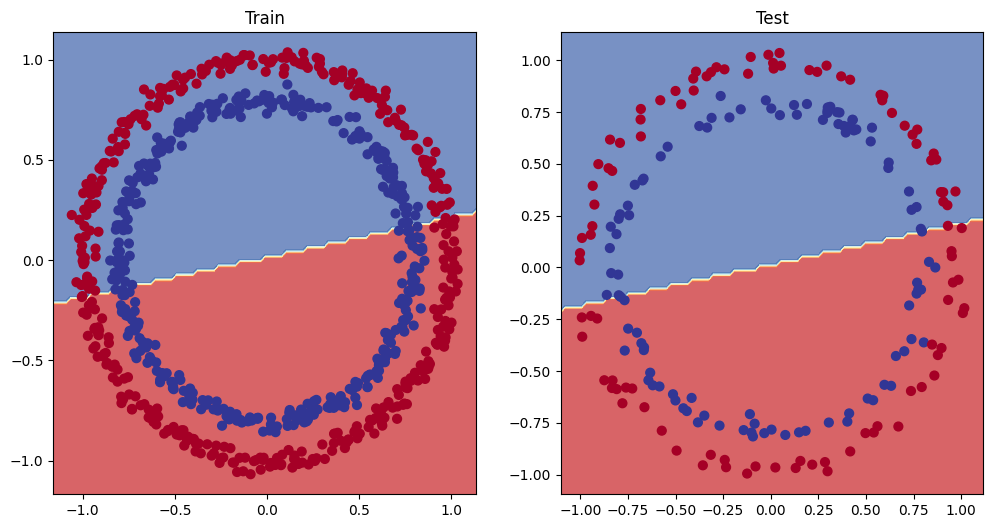

In [28]:
# define figure size
plt.figure(figsize=(12, 6))

# define subplot for training data
plt.subplot(1, 2, 1)
plt.title('Train')

# plot training data decision boundary
plot_decision_boundary(model_1, X_train, y_train)


# define subplot for test data
plt.subplot(1, 2, 2)
plt.title('Test')

# plot test data decision boundary
plot_decision_boundary(model_1, X_test, y_test)

# 5. Test our model on regression formula dataset from Notebook_01

In [29]:
# create data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [30]:
# split the data
train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# check the length
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

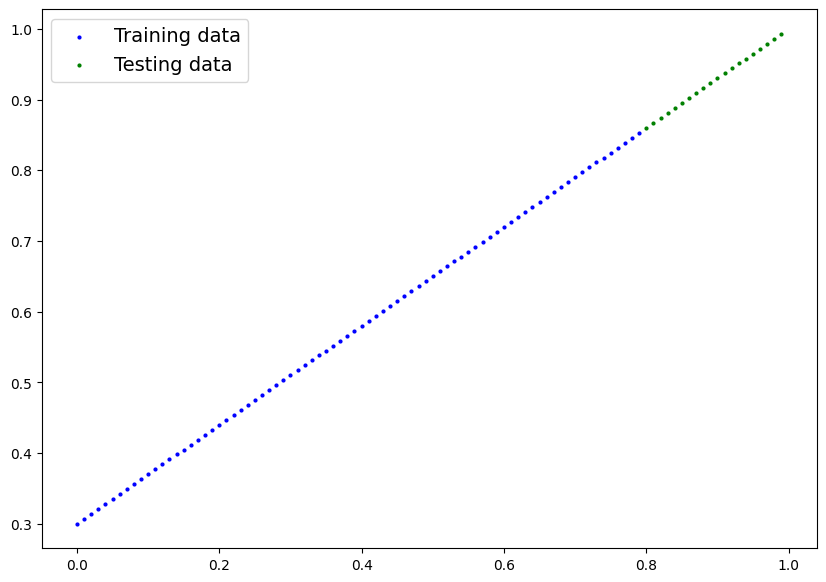

In [31]:
# vizualize the data
from helper_functions import plot_predictions

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [32]:
# setup seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# create a model with only 1 in_features
regression_model = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

# view the model
regression_model

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# setup loss for regression model
loss_fn = nn.L1Loss()

# setup optimizer for regression model
optimizer = torch.optim.SGD(params=regression_model.parameters(),
                            lr=0.1)

In [34]:
# setup random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epoch count
epochs = 1000

# put data on device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# setup training and evaluation loop
for epoch in range(epochs):
    regression_model.train()

    # forward pass
    y_preds = regression_model(X_train_regression)

    # calculate loss and accuracy
    train_loss = loss_fn(y_preds, y_train_regression)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backwards (backpropogation)
    train_loss.backward()

    # optimizer step
    optimizer.step()


    # test the model
    regression_model.eval()
    with torch.inference_mode():
        # forward pass
        test_preds = regression_model(X_test_regression)

        # calculate the loss
        test_loss = loss_fn(test_preds, y_test_regression)

    # print what is happening
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f}')

Epoch: 0 | Train Loss: 0.75986 | Test Loss: 0.54143
Epoch: 100 | Train Loss: 0.09309 | Test Loss: 0.02901
Epoch: 200 | Train Loss: 0.07376 | Test Loss: 0.02850
Epoch: 300 | Train Loss: 0.06745 | Test Loss: 0.00615
Epoch: 400 | Train Loss: 0.06107 | Test Loss: 0.02004
Epoch: 500 | Train Loss: 0.05698 | Test Loss: 0.01061
Epoch: 600 | Train Loss: 0.04857 | Test Loss: 0.01326
Epoch: 700 | Train Loss: 0.06109 | Test Loss: 0.02127
Epoch: 800 | Train Loss: 0.05599 | Test Loss: 0.01426
Epoch: 900 | Train Loss: 0.05571 | Test Loss: 0.00603


In [35]:
# make predictions
with torch.inference_mode():
    y_preds = regression_model(X_test_regression)

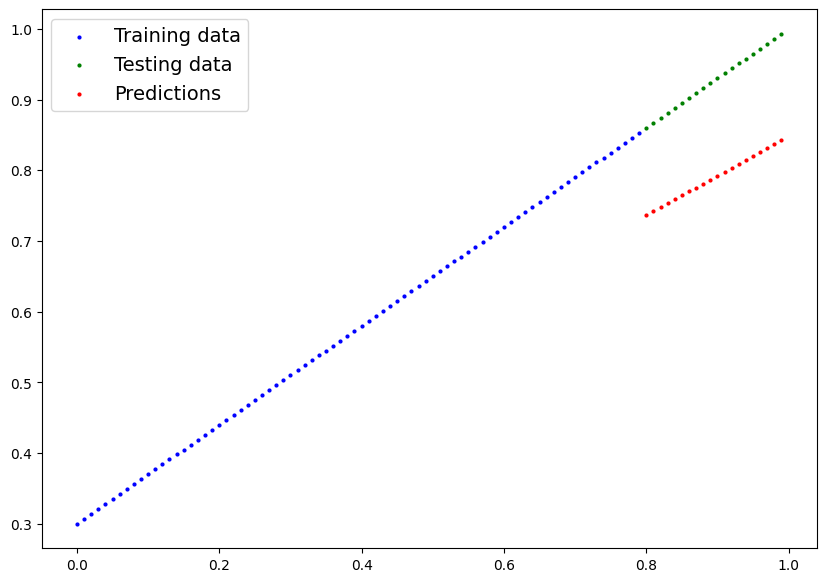

In [36]:
# plot the predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

# 6. Create a non linear model using `PyTorch`

In [37]:
# create model class for non linear model
class NonLinear(nn.Module):
    def __init__(self):
        super().__init__()

        # define model layers
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        # define a non-linear activation function
        self.relu = nn.ReLU()

    # define forward propogation
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# instanciate the model
non_linear_model = NonLinear().to(device)

# view model
non_linear_model

NonLinear(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [38]:
# define loss function
loss_fn = nn.BCEWithLogitsLoss()

# define optimizer
optimizer = torch.optim.SGD(params=non_linear_model.parameters(),
                            lr=0.1)

In [39]:
### construct a training and test loop

# define seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# define epoch range
epochs = 1000

# put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# loop
for epoch in range(epochs):
    non_linear_model.train()

    # forward pass
    y_logits = non_linear_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss and accuracy
    train_loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backwards (backpropogation)
    train_loss.backward()

    # optimizer step
    optimizer.step()


    # test the model
    non_linear_model.eval()

    with torch.inference_mode():
        # forward pass
        test_logits = non_linear_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # print what is happening
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {acc:.2f}% \n')

Epoch: 0 | Train Loss: 0.69295 | Train Accuracy: 50.00% | Test Loss: 0.69319 | Test Accuracy: 50.00% 

Epoch: 100 | Train Loss: 0.69115 | Train Accuracy: 52.88% | Test Loss: 0.69102 | Test Accuracy: 52.88% 

Epoch: 200 | Train Loss: 0.68977 | Train Accuracy: 53.37% | Test Loss: 0.68940 | Test Accuracy: 53.37% 

Epoch: 300 | Train Loss: 0.68795 | Train Accuracy: 53.00% | Test Loss: 0.68723 | Test Accuracy: 53.00% 

Epoch: 400 | Train Loss: 0.68517 | Train Accuracy: 52.75% | Test Loss: 0.68411 | Test Accuracy: 52.75% 

Epoch: 500 | Train Loss: 0.68102 | Train Accuracy: 52.75% | Test Loss: 0.67941 | Test Accuracy: 52.75% 

Epoch: 600 | Train Loss: 0.67515 | Train Accuracy: 54.50% | Test Loss: 0.67285 | Test Accuracy: 54.50% 

Epoch: 700 | Train Loss: 0.66659 | Train Accuracy: 58.38% | Test Loss: 0.66322 | Test Accuracy: 58.38% 

Epoch: 800 | Train Loss: 0.65160 | Train Accuracy: 64.00% | Test Loss: 0.64757 | Test Accuracy: 64.00% 

Epoch: 900 | Train Loss: 0.62362 | Train Accuracy: 74.00%

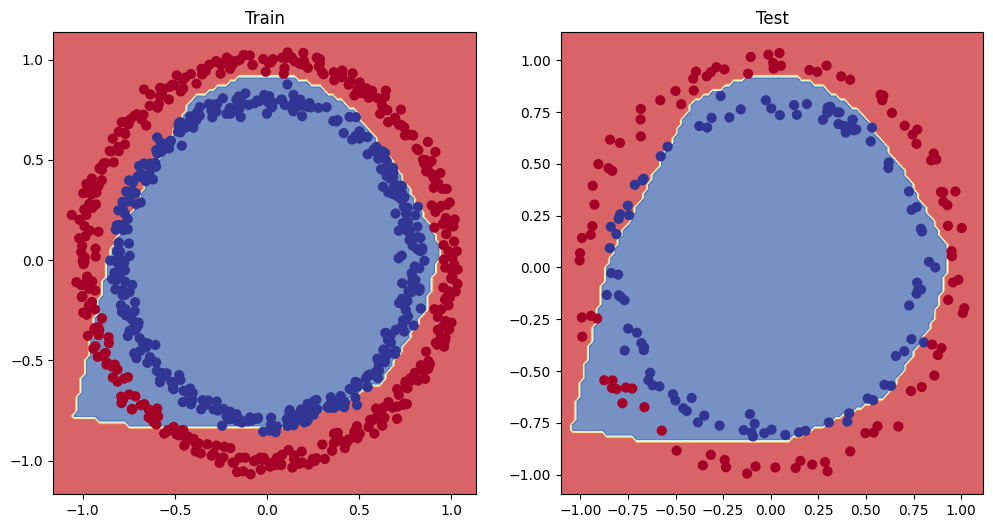

In [40]:
# plot decision boundary
# define figure size
plt.figure(figsize=(12, 6))

# define subplot for training data
plt.subplot(1, 2, 1)
plt.title('Train')

# plot training data decision boundary
plot_decision_boundary(non_linear_model, X_train, y_train)


# define subplot for test data
plt.subplot(1, 2, 2)
plt.title('Test')

# plot test data decision boundary
plot_decision_boundary(non_linear_model, X_test, y_test)

### 6.1 Improve non linear model

In [41]:
# define improved model

improved_non_linear_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=20),
    nn.ReLU(),
    nn.Linear(in_features=20, out_features=20),
    nn.ReLU(),
    nn.Linear(in_features=20, out_features=1),
).to(device)

# view the model
improved_non_linear_model

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=1, bias=True)
)

In [42]:
# define loss function
loss_fn = nn.BCEWithLogitsLoss()

# define optimizer
optimizer = torch.optim.SGD(params=improved_non_linear_model.parameters(),
                            lr=0.1)

In [43]:
# train the model

# setup seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# define epoch range
epochs = 1000

# get data on the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# loop through the data
for epoch in range(epochs):
    improved_non_linear_model.train()

    # forward pass
    y_logits = improved_non_linear_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss and accuracy
    train_loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backwards (backpropogation)
    train_loss.backward()

    # optimizer step
    optimizer.step()

    # test the model
    improved_non_linear_model.eval()

    with torch.inference_mode():
        # forward pass
        test_logits = improved_non_linear_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # print what is happening
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Train Loss: 0.69448 | Train Accuracy: 47.62% | Test Loss: 0.69 | Test Accuracy: 54.00
Epoch: 100 | Train Loss: 0.69102 | Train Accuracy: 53.12% | Test Loss: 0.69 | Test Accuracy: 56.50
Epoch: 200 | Train Loss: 0.68750 | Train Accuracy: 56.88% | Test Loss: 0.69 | Test Accuracy: 57.00
Epoch: 300 | Train Loss: 0.68379 | Train Accuracy: 59.62% | Test Loss: 0.68 | Test Accuracy: 59.50
Epoch: 400 | Train Loss: 0.67821 | Train Accuracy: 63.12% | Test Loss: 0.68 | Test Accuracy: 63.00
Epoch: 500 | Train Loss: 0.66898 | Train Accuracy: 69.50% | Test Loss: 0.67 | Test Accuracy: 72.00
Epoch: 600 | Train Loss: 0.65292 | Train Accuracy: 75.38% | Test Loss: 0.65 | Test Accuracy: 77.00
Epoch: 700 | Train Loss: 0.62314 | Train Accuracy: 85.62% | Test Loss: 0.63 | Test Accuracy: 84.00
Epoch: 800 | Train Loss: 0.56539 | Train Accuracy: 94.62% | Test Loss: 0.58 | Test Accuracy: 94.00
Epoch: 900 | Train Loss: 0.45988 | Train Accuracy: 99.38% | Test Loss: 0.48 | Test Accuracy: 98.00


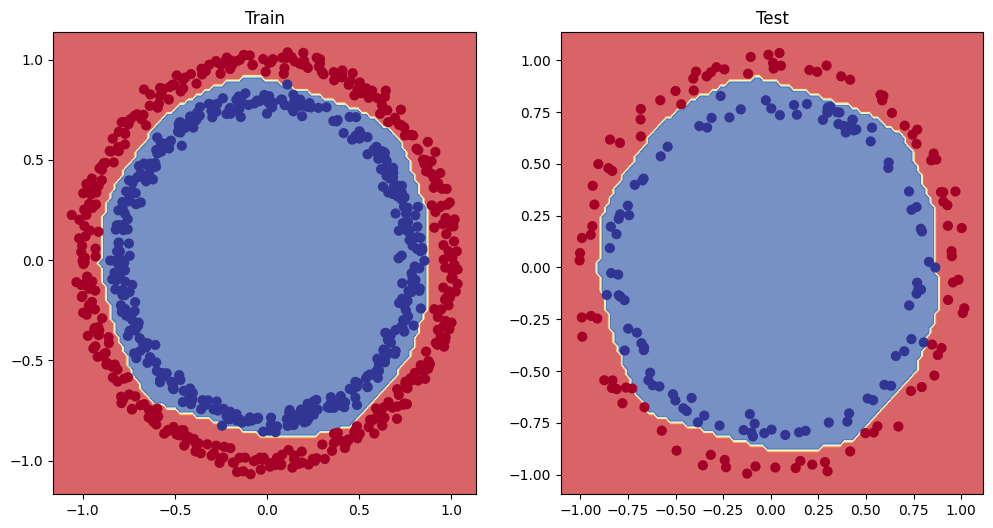

In [44]:
# plot descision boundary
# define figure size
plt.figure(figsize=(12, 6))

# define subplot for training data
plt.subplot(1, 2, 1)
plt.title('Train')

# plot training data decision boundary
plot_decision_boundary(improved_non_linear_model, X_train, y_train)


# define subplot for test data
plt.subplot(1, 2, 2)
plt.title('Test')

# plot test data decision boundary
plot_decision_boundary(improved_non_linear_model, X_test, y_test)

# 7. Multiclass Classification

### 7.1 Construct the data

In [45]:
from sklearn.datasets import make_blobs

# make 3 classes of data
X_blob, y_blob = make_blobs(n_samples=1000,
                                        n_features=2,
                                        centers=4,
                                        cluster_std=1.5,
                                        random_state=42)

# convert the data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# view the data
X_blob[:5], y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3., 2., 2., 1., 1.]))

### 7.2 Split the data

In [46]:
from sklearn.model_selection import train_test_split

# split the data into train and test split
X_train_blob, X_test_blob, y_train_blob, y_test_blob = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=42)

### 7.3 View the data

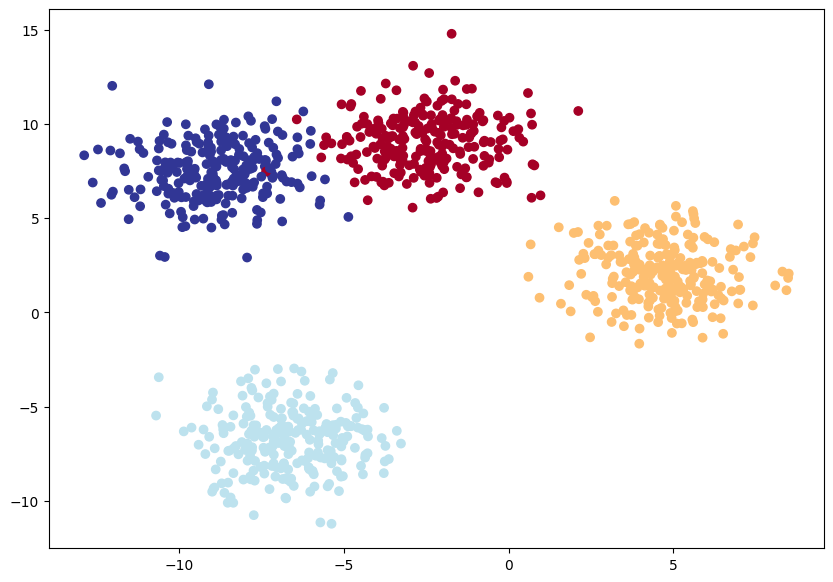

In [47]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 7.4 Build the model for multiclass classification

In [48]:
X_train_blob[:5]

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        [-6.0262, -4.4375],
        [-3.3397,  7.2175]])

In [77]:
# setup model class
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()

        # define layer stack
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    # define forward method
    def forward(self, x):
        return self.linear_layer_stack(x)

# instanciate model on the device
multiclass_model = BlobModel(input_features=2,
                             output_features=4,
                             hidden_units=8).to(device)


# view model
multiclass_model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 7.5 Setup loss function and optimizer

In [78]:
# setup loss function
loss_fn = nn.CrossEntropyLoss()

# setup optimizer
optimizer = torch.optim.SGD(params=multiclass_model.parameters(),
                            lr=0.1)

#### 7.5.1 Get prediction probabilitites for untrained model

In [79]:
# get prediction probabilities for data
with torch.inference_mode():
    y_logits = multiclass_model(X_test_blob.to(device))
    y_pred = torch.softmax(y_logits, dim=1)

# view the data
y_logits[:5], y_pred[:5]

(tensor([[ 0.8161, -0.8846, -0.2847,  0.4252],
         [-0.9359, -2.0669,  0.9583, -2.2816],
         [-0.6742, -0.0694,  0.8067, -1.3123],
         [ 0.6858, -0.5307, -0.1840,  0.3610],
         [ 0.1430, -1.9414,  0.1816, -0.8017]], device='cuda:0'),
 tensor([[0.4563, 0.0833, 0.1518, 0.3087],
         [0.1215, 0.0392, 0.8077, 0.0316],
         [0.1289, 0.2361, 0.5669, 0.0681],
         [0.4102, 0.1215, 0.1719, 0.2964],
         [0.3918, 0.0487, 0.4072, 0.1523]], device='cuda:0'))

### 7.6 Train multiclass model

In [80]:
# setup seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# setup epoch range
epochs = 100

# put data on device
X_train_blob, y_train_blob = X_train_blob.to(device), y_train_blob.to(device)
X_test_blob, y_test_blob = X_test_blob.to(device), y_test_blob.to(device)

# loop through the data
for epoch in range(epochs):
    # set model to train
    multiclass_model.train()

    # forward pass
    y_logits = multiclass_model(X_train_blob)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # calculate the loss
    train_loss = loss_fn(y_logits, y_train_blob.long())
    acc = accuracy_fn(y_train_blob, y_preds)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backwards
    train_loss.backward()

    # optimizer step
    optimizer.step()

    ### test the model
    with torch.inference_mode():
        # set model to eval
        multiclass_model.eval()

        # forward pass
        test_logits = multiclass_model(X_test_blob)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # calculate the loss
        test_loss = loss_fn(test_logits, y_test_blob.long())
        test_acc = accuracy_fn(y_test_blob, test_preds)

    # print what is happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f} | Train Accuracy: {acc:2f}% | Test Accuracy: {test_acc:2f}%')

Epoch: 0 | Train Loss: 1.92116 | Test Loss: 0.85459 | Train Accuracy: 26.000000% | Test Accuracy: 55.000000%
Epoch: 10 | Train Loss: 0.28521 | Test Loss: 0.23787 | Train Accuracy: 97.125000% | Test Accuracy: 98.000000%
Epoch: 20 | Train Loss: 0.11618 | Test Loss: 0.10434 | Train Accuracy: 99.000000% | Test Accuracy: 98.500000%
Epoch: 30 | Train Loss: 0.07650 | Test Loss: 0.06791 | Train Accuracy: 99.000000% | Test Accuracy: 98.500000%
Epoch: 40 | Train Loss: 0.06006 | Test Loss: 0.05209 | Train Accuracy: 99.000000% | Test Accuracy: 99.000000%
Epoch: 50 | Train Loss: 0.05133 | Test Loss: 0.04346 | Train Accuracy: 99.000000% | Test Accuracy: 99.000000%
Epoch: 60 | Train Loss: 0.04599 | Test Loss: 0.03807 | Train Accuracy: 99.000000% | Test Accuracy: 99.500000%
Epoch: 70 | Train Loss: 0.04242 | Test Loss: 0.03440 | Train Accuracy: 99.000000% | Test Accuracy: 99.500000%
Epoch: 80 | Train Loss: 0.03989 | Test Loss: 0.03174 | Train Accuracy: 99.000000% | Test Accuracy: 99.500000%
Epoch: 90 |

#### 7.6.1 Making predictions of trained model

In [81]:
# making predictions
multiclass_model.eval()
with torch.inference_mode():
    y_logits = multiclass_model(X_test_blob)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

# view the data
y_pred[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

### 7.7 Visualizing the decision boundary

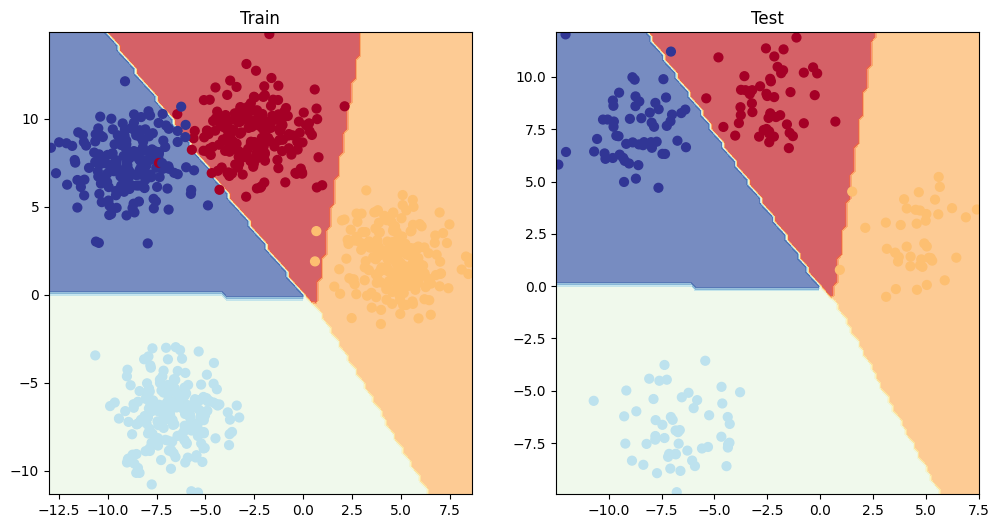

In [82]:
# setup figure
plt.figure(figsize=(12, 6))

# plot training data
plt.subplot(1, 2, 1)
plt.title('Train')

# plotting decision boundary
plot_decision_boundary(multiclass_model, X_train_blob, y_train_blob)

# plot test data
plt.subplot(1, 2, 2)
plt.title('Test')

# plotting decision boundary
plot_decision_boundary(multiclass_model, X_test_blob, y_test_blob)